# Clusterização (Agrupamento)

Objetivo é criar grupos de veículos similares

In [1]:
import findspark
findspark.init()

In [51]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row # Pré Processar os dados
from pyspark.ml.linalg import Vectors
import pandas as pd
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Carregando os Dados

In [3]:
sc = SparkContext(appName = 'Lab5')

In [4]:
spSession = SparkSession.builder.master('local').getOrCreate()

In [5]:
carrosRDD = sc.textFile("C:/formacao_dataScience_DSA_DADOS/01_bigData_RealTime_Python_Spark/cap14_Apache_Spark_MLlib/Lab5/dados/dataset5.csv")

In [6]:
carrosRDD.collect()

['fabricante,tipo_combustivel,aspirado,portas,tipo,direcao,cilindros,horsepower,rpm,consumo_cidade,consumo_estrada,preco',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389',
 'honda,gas,std,two,hatchback,fwd,four,60,5500,38,42,5399',
 'nissan,gas,std,two,sedan,fwd,four,69,5200,31,37,5499',
 'dodge,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572',
 'plymouth,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,31,38,6095',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,31,38,6189',
 'dodge,gas,std,four,hatchback,fwd,four,68,5500,31,38,6229',
 'plymouth,gas,std,four,hatchback,fwd,four,68,5500,31,38,6229',
 'chevrolet,gas,std,two,hatchback,fwd,four,70,5400,38,43,6295',
 'toyota,ga

In [7]:
carrosRDD.take(5)

['fabricante,tipo_combustivel,aspirado,portas,tipo,direcao,cilindros,horsepower,rpm,consumo_cidade,consumo_estrada,preco',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']

In [9]:
# Removendo a primeira linha do arquivo
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [11]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

# Pré Processamento dos Dados

In [13]:
# Convertendo e limpando os dados

def transformToNumeric(inputStr):
    
    # Divide a linha em colunas
    attList = inputStr.split(',')
    
    # Aplica Label Encoding para as colunas de índice 3 e 4
    doors = 1.0 if attList[3] == 'two' else 2.0
    body = 1.0 if attList[4] == 'sedan' else 2.0
    
    # Usaremos somente algumas variáveis do conjunto de dados oriignal
    linhas  = Row(DOORS = doors,
                 BODY = float(body),
                 HP = float(attList[7]),
                 RPM = float(attList[8]),
                 MPG = float(attList[9]))
    
    return linhas

In [15]:
# Aplicando a função ao RDD
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.take(5)

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0)]

In [17]:
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|70.0|5400.0|38.0|
|  1.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|58.0|4800.0|49.0|
|  2.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|76.0|6000.0|30.0|
|  2.0| 1.0|70.0|5400.0|38.0|
+-----+----+----+------+----+
only showing top 20 rows



In [18]:
carrosDF.show(5)

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
+-----+----+----+------+----+
only showing top 5 rows



### Padronização 

In [23]:
# Sumarizando os dados e extraindo a média e o desvio padrão
estats = carrosDF.describe().toPandas()
estats.head()

,summary,DOORS,BODY,HP,RPM,MPG
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359884,37.63920534951835,481.03591405011446,6.437862917085912
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


In [25]:
# Extraindo média e o desvio padrão
medias = estats.iloc[1,1:6].values.tolist()
desvios = estats.iloc[2,1:6].values.tolist()
medias

['1.5685279187817258',
 '1.532994923857868',
 '103.60406091370558',
 '5118.0203045685275',
 '25.15228426395939']

In [27]:
# Colocando a média e o desvio padrão em variáveis do tipo Broadcast (disponivel em todo cluster)
bc_media = sc.broadcast(medias)
bc_desvios = sc.broadcast(desvios)

In [28]:
# Função para centrlizar e aplicar escaala aos dados, gerando vetor de saída
# Cada valor será subtraido da média e então dividio pelo desvio padrão

def centerAndScale(inRow):
    
    # Variáveis globais
    global bc_media
    global bc_desvios
    
    # Array de médias e desvios
    meanArray = bc_media.value
    stdArray = bc_desvios.value
    
    # Array para o resultado
    retArray = []
    
    # Loop para o cálculo
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[1])) / float(stdArray[i]))
        
    return Vectors.dense(retArray)

In [29]:
# Aplicando a função 
carrosRDD4 = carrosDF.rdd.map(centerAndScale)

In [32]:
carrosRDD4.collect()

[DenseVector([-1.0734, 0.9337, 1.7925, 10.1832, 4.5771]),
 DenseVector([-1.0734, 0.9337, 1.2345, 10.5989, 7.0624]),
 DenseVector([-1.0734, 0.9337, 1.7659, 10.391, 4.4218]),
 DenseVector([-1.0734, 0.9337, 1.6065, 9.9753, 5.1985]),
 DenseVector([-1.0734, 0.9337, 1.7659, 11.4305, 5.5091]),
 DenseVector([-1.0734, 0.9337, 1.5534, 11.4305, 5.6645]),
 DenseVector([-1.0734, -1.0656, 1.7925, 10.8068, 4.5771]),
 DenseVector([-1.0734, 0.9337, 1.7659, 11.4305, 5.5091]),
 DenseVector([-1.0734, 0.9337, 1.7659, 11.4305, 5.5091]),
 DenseVector([-1.0734, 0.9337, 1.7659, 10.391, 4.5771]),
 DenseVector([-1.0734, 0.9337, 1.7659, 11.4305, 4.5771]),
 DenseVector([0.9405, 0.9337, 1.7659, 11.4305, 4.5771]),
 DenseVector([0.9405, 0.9337, 1.7659, 11.4305, 4.5771]),
 DenseVector([-1.0734, 0.9337, 1.819, 11.2226, 5.6645]),
 DenseVector([-1.0734, 0.9337, 1.6065, 9.9753, 4.5771]),
 DenseVector([-1.0734, 0.9337, 1.7659, 11.4305, 4.5771]),
 DenseVector([-1.0734, 0.9337, 1.5002, 9.9753, 7.3731]),
 DenseVector([0.9405,

In [34]:
# Criando um DataFrame
carrosRDD5 = carrosRDD4.map(lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
+--------------------+
only showing top 5 rows



In [35]:
carrosDF.show(10)

+--------------------+
|            features|
+--------------------+
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
|[-1.0734102732927...|
+--------------------+
only showing top 10 rows



# Machine Learning

In [63]:
# Cria o modelo 
kmeans = KMeans(k = 2, # Número de grupos
                seed = 1) #

In [64]:
# Treinando o modelo
modelo = kmeans.fit(carrosDF)

In [65]:
# Previsoes
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[0.94051185850411...|         0|
|[0.94051185850411...|         0|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[-1.0734102732927...|         1|
|[0.94051185850411...|         0|
|[-1.0734102732927...|         1|
|[0.94051185850411...|         0|
+--------------------+----------+
only showing top 20 rows



In [66]:
# Crinado funções para extrair os atributos previstos
def unstripData(instr):
    return(instr['prediction'],
          instr['features'][0],
          instr['features'][1],
          instr['features'][2],
          instr['features'][3],
          instr['features'][4],)

In [67]:
# Aplica a função nas previsções
carrosRDD6 = previsoes.rdd.map(unstripData)

In [68]:
predList = carrosRDD6.collect()

In [69]:
predList

[(1,
  -1.073410273292738,
  0.933671681480512,
  1.7924662449603355,
  10.18316275771006,
  4.577140808316609),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.2345373565846747,
  10.598932129930288,
  7.0624375917470905),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.7658982026567327,
  10.391047443820174,
  4.421809759352204),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.6064899488351152,
  9.975278071599945,
  5.198465004174229),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.7658982026567327,
  11.430470874370744,
  5.509127102103039),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.5533538642279094,
  11.430470874370744,
  5.6644581510674445),
 (1,
  -1.073410273292738,
  -1.0656035495158016,
  1.7924662449603355,
  10.806816816040403,
  4.577140808316609),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.7658982026567327,
  11.430470874370744,
  5.509127102103039),
 (1,
  -1.073410273292738,
  0.933671681480512,
  1.7658982026567327,
  11.43047087437

In [70]:
#  cOVERTENDO EM dATAfRAME DO pANDAS
predPD = pd.DataFrame(predList)

In [71]:
predPD.head(20)

,0,1,2,3,4,5
0,1,-1.073410,0.933672,1.792466,10.183163,4.577141
1,1,-1.073410,0.933672,1.234537,10.598932,7.062438
2,1,-1.073410,0.933672,1.765898,10.391047,4.421810
3,1,-1.073410,0.933672,1.606490,9.975278,5.198465
4,1,-1.073410,0.933672,1.765898,11.430471,5.509127
5,1,-1.073410,0.933672,1.553354,11.430471,5.664458
6,1,-1.073410,-1.065604,1.792466,10.806817,4.577141
7,1,-1.073410,0.933672,1.765898,11.430471,5.509127
8,1,-1.073410,0.933672,1.765898,11.430471,5.509127
9,1,-1.073410,0.933672,1.765898,10.391047,4.577141


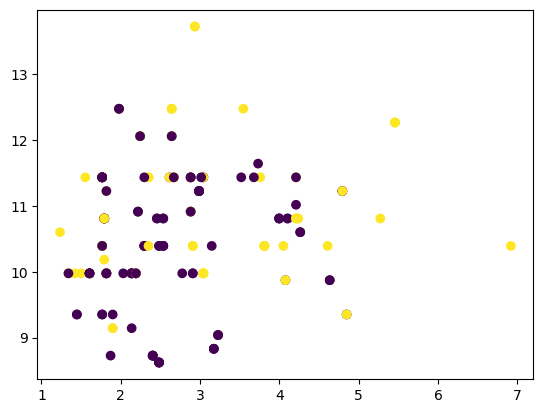

In [72]:
# Gráfico com o resultado dos clusters criados
plt.cla()
plt.scatter(predPD[3], predPD[4], c = predPD[0])